# PeakIdentify - Example and Functionality

***

This notebook walks you through the usage and functionality of the peakidentify function. First, the functionality will be shown by just calling the wrapper function, but subsequent examples will explore the sub-functions and explain their usage. 

This function was created by the Raman Noodles Dev Team, and we hope you find it to your liking. Feel free to leave issues for suggested improvments. 

### Example 1: Wrapper Function - peak_assignment

First, we'll generate the dataset that we will use to explore this functionality. This data will be downloaded from the NIST Webbook database. In order to generate an "unknown spectrum" that we will be attempting to fit, we'll combine together the data from two different compounds, and feed that in as our unknown dataset. For further explanation of the shoyu or spectrafit packages, refer to the Jupyter notebooks which present examples of their usage, also found in this repo.

In [1]:
import math
import pickle
import matplotlib.pyplot as plt
import numpy as np
from ramannoodles import spectrafit
from ramannoodles import shoyu
from ramannoodles import peakidentify

In [2]:
# open spectra library
shoyu_data_dict = pickle.load(open('../raman_spectra/shoyu_data_dict.p', 'rb'))
# list keys
sorted(shoyu_data_dict.keys())

['2-PROPANOL',
 'CARBON DIOXIDE',
 'CARBON MONOXIDE',
 'DIMETHYL KETONE',
 'ETHYL ALCOHOL',
 'FORMIC ACID',
 'N-PENTANE',
 'WATER']

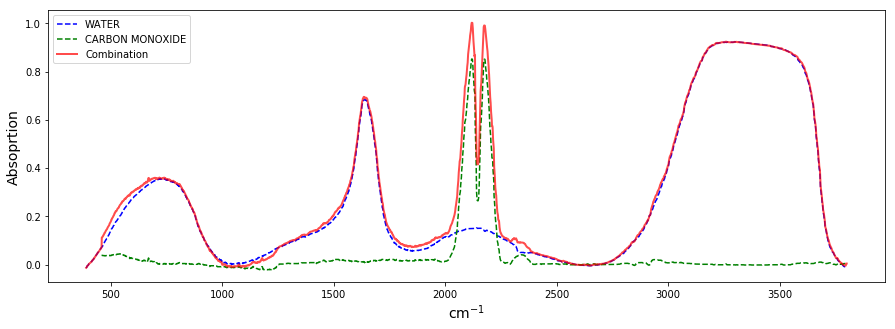

In [3]:
#Pull out individual entries from our broad dictionary and assign them into individual variables so
#they can be referenced separately. 
compound_1 = shoyu_data_dict['WATER']
compound_2 = shoyu_data_dict['CARBON MONOXIDE']
compound_3 = shoyu_data_dict['CARBON DIOXIDE']

#Use shoyu.py's functionality to combine the water and carbon monoxide data, and save the output.
#Then, typecast the variables into numpy arrays. 
unknown_x, unknown_y = shoyu.combine_spectra(compound_1, compound_2, plot = True)

#Finally, let's generate a list for our search space.
list_of_compounds = [compound_1, compound_2, compound_3]

### Great! Now that our data is built, we'll begin to work with the `peak_assignment` function.

`peak_assignment` takes as parameters five arguments, of which 2 are optional. First, we must pass the wavenumber data for x_value, which is the `unknown_x` value we generated above. The second parameter is the absorption data for y_value, which is generated as `unknown_y` above. The third parameter contains a list of all of the compounds that you want to check your unknown data for. In other words, if a compound data is not passed in this list, then the function will not look to see if that compound is present in your unknown spectrum. This is the list that we generated above titled `list_of_compounds`, which we passed data for carbon monoxide, water, and carbon dioxide. Parameter 4 is `precision`, which is an optional parameter. It is defaulted to 0.03, but can be adjusted by passing a different float value. What it does is it sets a boundary for how close the known peak position has to be to an unknown peak for the function to assign the peak. It is a percentage value, so 0.03 is 3 % of the larger of the two peak positions. Finally, parameter 5 is `plot`, which is also an optional parameter. It is a Boolean which defaults to True. If True, this will plot the unknown specrta and labels for all of the peaks in said spectra. 

For our example, we won't mess with those optional parameters.

The peaks that we found for WATER are: 
[711.4826030832157, 1638.6886199554203, 3312.1231809302135]
The peaks that we found for CARBON MONOXIDE are: 
[2109.8548231081886, 2183.58416497579]
The peaks that we found for CARBON DIOXIDE are: 
[620.6820993063426, 652.1156598823245, 680.3282599999995, 723.8750859253754, 2304.1651179999994, 2336.8755009789434, 3590.9856357827366, 3621.8934979836718, 3692.2514877580816, 3720.4308850577695]
[['WATER', 'CARBON DIOXIDE'], ['WATER'], ['CARBON MONOXIDE'], ['CARBON MONOXIDE'], ['WATER']]


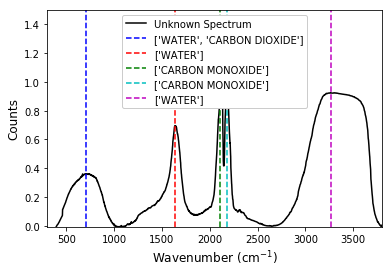

{'WATER': 100.0, 'CARBON MONOXIDE': 100.0, 'CARBON DIOXIDE': 10.0}


In [4]:
peakidentify.peak_assignment(unknown_x, unknown_y, list_of_compounds)

### Excellent!

Because plot = True, we see a plot of our unknown spectra with lines indicating the positions of identified possible components. One thing to note! For the blue vertical line, you can see that the peak labelling function has assigned not just one, but two possible peaks to this position. This happens because both water (the correct compound) and carbon dioxide (the incorrect compound) contain peaks that exist in similar locations within the `precision` error bound. To provide additional clarity as to the likelihood of which peaks are correctly assigned, and which are not, a dictionary is printed out after showing the plot. The dictionary contains the name of the compound, followed by a percentage. The percentage is generated by comparing the total number of peaks in the Raman spectra that are found in the unknown spectra. For example, if 1 peak out of 10 possible are found as is the case for carbon dioxide above, it will show a percentage of 10%, whereas for water if it find 3 peaks out of a possible 3, the percentage reported is 100%. This percentage provides an approximate degree of confidence for how likely it is that a compound is present. 

For this above example, because we see that water and carbon monoxide show a 100% detection percentage, we're quite confident that they are in-fact present in our unknown sample; however, as carbon dioxide only shows a 10% detection percentage, it's not very likely that it is present in our unknown sample. That said, the final value judgement is left to the user, as these percentages are just approximate guidelines. 

***

# Example 2 - Individual Functions of `peakidentify.py`

***

Ok! Now that you've seen the broad usage of `peakidentify.py`, we'll walk through the individual functions and spend a bit more time really explaining each individual use-case.

You have already been introduced to the first function, a wrapper function called `peak_assignment`. Following this, the next function is `compare_unknown_to_known`. This function takes in the peak positions (the wavenumber position for the peak position) for the unknown's spectrum, and compares it to the peaks positions for a **single** known compound. 

`compare_unknown_to_known` takes 3 parameters. The first parameter, `combined_peaks` is the peak positions of the unknown peaks. The second parameter, `known_peaks`, is the peak positions of one of the known compounds. The third parameter is `precision`, which is the maximum percentage difference between an unknown peak position and a known peak position that will be accepted as close enough to give a positive assignment. The function returns a parameter `association_matrix`, which contains a list of either 1 or 0, which is the assignment value of whether or not a peak from the unknown peak set was found in the passed known peak set. 

We'll need to generate some data to pass along, then call the function directly.

In [5]:
water_peaks = spectrafit.compound_report(compound_1)[0]
co_peaks = spectrafit.compound_report(compound_2)[0]
unknown_peaks = spectrafit.data_report(unknown_x, unknown_y)[0]

In [7]:
peakidentify.compare_unknown_to_known(unknown_peaks, water_peaks, 0.03)

array([1., 1., 0., 0., 1.])

In [8]:
peakidentify.compare_unknown_to_known(unknown_peaks, co_peaks, 0.03)

array([0., 0., 1., 1., 0.])

Great! So, this function, when called to compare water to the unknown peaks, or carbon monoxide to the unknown peaks, we see that it returns an array of 1 and 0. This array is an assignment array. If the array contains a 0, the peak in that position is not found in the known compound. For example, for the water peak comparison, the value of the returned array is 1 at position 0. That means that it is assigning the peak found at position 0 to be possibly coming from water. The 0 in position 2 implies that the unknown peak is not found in water. If we look at position 2 in the carbon monoxide comparison, we see that it is a 1 there. This implies that the peak in position 2, is likely not coming from water, and could possibly be coming from carbon monoxide.

The next function to investigate is the `peak_position_comparisons`. It takes four parameters. The first is the list of unknown peaks, and the second is the complete list of peaks for known compounds. The third is the list of compounds that the wrapper function should search through. The fourth is the complete association matrix output from the `compare_unknown_to_known` function. By appending together the matrices returned by that function, the full association_matrix is built. We will build a full association matrix, and then pass it to our `peak_position_comparisons` function.

In [10]:
#Build our test data.
co2_peaks = spectrafit.compound_report(compound_3)[0]
association_matrix = []
known_peaks = [[water_peaks], [co_peaks], [co2_peaks]]
association_matrix.append(peakidentify.compare_unknown_to_known(unknown_peaks, water_peaks, 0.03))
association_matrix.append(peakidentify.compare_unknown_to_known(unknown_peaks, co_peaks, 0.03))
association_matrix.append(peakidentify.compare_unknown_to_known(unknown_peaks, co2_peaks, 0.03))
print(association_matrix)

[array([1., 1., 0., 0., 1.]), array([0., 0., 1., 1., 0.]), array([1., 0., 0., 0., 0.])]


In [11]:
peakidentify.peak_position_comparisons(unknown_peaks, known_peaks, list_of_compounds, association_matrix)

[['WATER', 'CARBON DIOXIDE'],
 ['WATER'],
 ['CARBON MONOXIDE'],
 ['CARBON MONOXIDE'],
 ['WATER']]

Great! This function returns a list that shows all of the possible assignments for every peak, in a text format. We can see that for the unknown peak in position 0, there is a potential for that peak to have come from water or carbon dioxide, whereas the peak in position 2, is labelled as carbon monoxide. If this function does not find any possible compound for a peak, it returns a value of 'unassigned', which we will show below.  

In [15]:
peakidentify.peak_position_comparisons(unknown_peaks, [water_peaks], [compound_1], [[1,1,0,0,1]])

[['WATER'], ['WATER'], ['Unassigned'], ['Unassigned'], ['WATER']]

As you can see, if the peak isn't found, it labels the value as 'unassigned'! 

The next function to be explored is `percentage_of_peaks_found`. 

In [51]:
#Writing a wrapper function that calls stuff and keeps everything organized. 
def peak_assignment(unknown_x, unknown_y, known_compound_list, precision = 0.03, plot = True):
    """This function is a wrapper function from which all classification of peaks occurs."""
    #Lets identify the peaks in the unknown spectrum. 
    unknown_peaks = spectrafit.data_report(unknown_x, unknown_y)[0]
    
    #OK, next identify all of the peaks present in the known compound set. 
    #For efficiency, we'll also compare them against the unknown in the same for loop.
    known_compound_peaks = []
    assignment_matrix = []
    
    for i in range(len(known_compound_list)):
        known_compound_peaks.append(spectrafit.compound_report(known_compound_list[i])[0])
        print("The peaks that we found for " + str(known_compound_list[i]['title']) + " are: ")
        print(known_compound_peaks[i])
        assignment_matrix.append(compare_unknown_to_known(unknown_peaks, known_compound_peaks[i], precision))
    
    #Ok, so that generates a full association matrix that contains everything we need to assign peaks. 
    #Now, let's go through and actually assign text to peaks. 
    unknown_peak_assignments = peak_position_comparisons(unknown_peaks, known_compound_peaks, known_compound_list, assignment_matrix)
    print(unknown_peak_assignments)
    
    if plot:
        plotting_peak_assignments(unknown_x, unknown_y, unknown_peaks, unknown_peak_assignments)
    
    percentages = percentage_of_peaks_found(known_compound_peaks, assignment_matrix, known_compound_list)
    print(percentages)

In [44]:
#Ok, instead of what I've done here, I should use the assignment matrix to classify percentages. 
def percentage_of_peaks_found(known_peaks, association_matrix, list_of_known_compounds):
    """This function takes in a list of classified peaks, and returns a percentage of how many of the material's
    peaks are found in the unknown spectrum. This can be used as a metric of confidence."""
    percentage_dict = {}
    for i in range(len(list_of_known_compounds)):
        count_number = sum(association_matrix[i])
        percentage_dict[list_of_known_compounds[i]['title']] = (count_number/len(known_peaks[i]))*100
        
    return percentage_dict

In [79]:
def plotting_peak_assignments(unknown_x, unknown_y, unknown_peaks, unknown_peak_assignments):
    """This function plots a set of unknown peaks, and plots the assigned classification given by
    the functions within peakassignment"""
    colors = ['b', 'r', 'g', 'c', 'm', 'y', 'b']
    fig = plt.figure(figsize = (10,4), dpi = 300)
    plt.plot(unknown_x, unknown_y, color = 'black', label = 'Unknown Spectrum')
    for i in range(len(unknown_peaks)):
        plt.axvline(x = unknown_peaks[i], color = colors[i], label = unknown_peak_assignments[i], linestyle = '--')
    plt.legend(loc=0, framealpha=1)
    plt.xlabel('Wavenumber (cm$^{-1}$)', fontsize=12)
    plt.ylabel('Counts', fontsize=12)
    plt.ylim(-0.01, 1.5)
    plt.xlim(300,3800)
    plt.show()

### As mentioned above, we should also take a look at reporting the prediction of the peak in terms of fit confidence.  This score function should be considered as a first visual grading that your peaks are close enough to determine matching. We will provide a simplistic 1D Euclidean distance calculation. 

***

### The reciprocal of the distance is returned as a percentage of distance comparison in the x dimension with 1 equalling peak centers that are super close and 0 super far away respectively. A tuple of the two peak locations compared is returned for visual confirmation of the score.

*** 
### This scoring function also includes the user input for the choice of normalizing the peak distance scores and sorting them based on the  kth highest score in the peak set. This normalization is performed to bring a better understanding to the peak distance confidence score, and it also allows for future work to be done in determining the best kth highest score normalization to be used. The default k for peak_1d_score is zero and is simlpy an integer.

In [35]:
peakidentify.peak_1d_score(co_peaks,spectra_peaks,1)

([0.8732275399042558, 0.6389821499520236],
 [(2109.8548231081886, 2110.0000000000095),
  (2183.58416497579, 2184.149153919652)])

### In the score_max function calls upon the peak_1D_score to get the highest score = 1 and then will normalize the rest of the score data respectively. Here, the user can input different k values for the # k highest score to be normalized over.

In [16]:
scoremaxk1=peakidentify.score_max(co_peaks,spectra_peaks,k=1)

([1.0, 0.7317475924111191],
 [(2109.8548231081886, 2110.0000000000095),
  (2183.58416497579, 2184.149153919652)])

### The score_sort function just appends the score max normalized scores and peak tuples to a list. There is no additional sorting feature added since the score max function already sorts the scores from the lowest to highest peak tuples compared.

In [47]:
data=peakidentify.score_sort(spectra_peaks,water_peaks,k=1)
print(data)

[([0.2607316955355646, 1.0, 0.026488495998529857], [(708.0, 711.4826030832157), (1638.5198632531205, 1638.6886199554203), (3268.999999970273, 3312.1231809302135)])]


### The user should spend some time evaluating how to visually grade their peak distance closeness. It might make sense in some cases to not have a normalized highest peak score. This last example showcases how different k values interact with the score grading. The final k value will output the original not normalized score.

In [29]:
k_range = range(1,len(spectra_peaks))
for k in k_range:
    compdf = pd.DataFrame(data=peakidentify.score_sort(spectra_peaks,water_peaks,k)[0][0][:],columns=['WATER_vs_CO_WATER_Combo_Scores'])
    compdf=compdf.assign(WATER_vs_CO_WATER__Combo_Peaks=peakidentify.score_sort(spectra_peaks,water_peaks,k)[0][1][:])
    compdf2=pd.DataFrame(data=peakidentify.score_sort(spectra_peaks,co_peaks,k)[0][0][:],columns=['CO_vs_CO_WATER__Combo_Scores'])
    compdf2=compdf2.assign(CO_vs_CO_WATER__Combo_peaks=peakidentify.score_sort(spectra_peaks,co_peaks,1)[0][1][:])
    print('This score is normalized over the #'+str(k) + ' highest score in the peak set')
    print(compdf)
    print(compdf2)



This score is normalized over the #1 highest score in the peak set
   WATER_vs_CO_WATER_Combo_Scores            WATER_vs_CO_WATER__Combo_Peaks
0                        0.260732                (708.0, 711.4826030832157)
1                        1.000000  (1638.5198632531205, 1638.6886199554203)
2                        0.026488   (3268.999999970273, 3312.1231809302135)
   CO_vs_CO_WATER__Combo_Scores               CO_vs_CO_WATER__Combo_peaks
0                      1.000000  (2110.0000000000095, 2109.8548231081886)
1                      0.731748     (2184.149153919652, 2183.58416497579)
This score is normalized over the #2 highest score in the peak set
   WATER_vs_CO_WATER_Combo_Scores            WATER_vs_CO_WATER__Combo_Peaks
0                        1.000000                (708.0, 711.4826030832157)
1                        3.835360  (1638.5198632531205, 1638.6886199554203)
2                        0.101593   (3268.999999970273, 3312.1231809302135)
   CO_vs_CO_WATER__Combo_Scores     